# Notebook to Analyze Results of Validation on Jobs
***
## Validation set notes:
- 555 total instances
- 278 defective products
- 277 satisfactory products

## Training set notes:
- 1667 instances
- 833 defective products
- 830 satisfactory products
***
## Imports

In [1]:
import h5py
import cv2
import joblib
import matplotlib.pyplot as plt
import jobsConfig as config
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, precision_recall_curve, roc_curve, roc_auc_score

## Initializations 

In [2]:
#Grab images
val = h5py.File(config.VAL_HDF5, "r")
images = val["images"]

#Grab Features
features = h5py.File(config.VAL_FEATURES, "r")["features"]

#Load in model
colorstorm = joblib.load(config.MODEL_PATH)

#Get ground truths and predictions
results = pd.read_csv(config.VAL_RESULTS).drop(columns = ["Unnamed: 0"])
y, y_pred = results["GroundTruth"], results["Prediction"]

***
## Confusion Matrix

In [3]:
confusion_matrix(y,y_pred)

array([[276,   2],
       [  0, 277]], dtype=int64)

__Confusion Matrix Notes__

AI jobs properly classifies 276 true negatives and 277 true positives. jobs does produce any false negatives on validation data (jobs never predicted the product was defective when it was usable - Type II Error), thus jobs will ensure that we are maximizing usable product. jobs does throw some false positves (jobs predicts the product was usable when infact it was not - Type I Error). However, false positves only happened twice. This behavior is undesired. In production, jobs should be more prone to saying a product is defective when it is not (false negatives). It may be wise to train jobs on more defective products to ensure a bias towards false negatives.
### Misclassified images

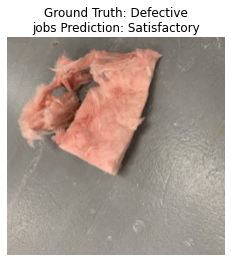

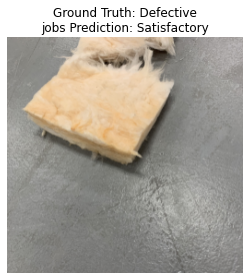

In [4]:
results["InvScore"] = results["GroundTruth"] != results["Prediction"]
misclassified_images = images[:][results["InvScore"]]

def demo(X, y, y_pred):

    for i, (img, grnd_tr, pred) in enumerate(zip(X, y, y_pred)):
        if grnd_tr == 0:
            grnd_tr = "Defective"
        else:
            grnd_tr = "Satisfactory"
        if pred == 0:
            pred = "Defective"
        else:
            pred = "Satisfactory"
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig = plt.figure(i)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Ground Truth: {}\njobs Prediction: {}".format(grnd_tr, pred))
        
    #Show the figure
    plt.tight_layout()
    
demo(misclassified_images.astype("uint8"), results["GroundTruth"][results["InvScore"] == 1], results["Prediction"][results["InvScore"] == 1])

Looking at the misclassified images above it appears that both images contain lots of background space (e.g. the gray floor). jobs may have learned to recognize defects based on the patterns in the floor. Additionally, each misclassifcation contains somewhat large rectangular regions compared the the area of the defects, these large rectangular regions may be causing jobs to flag these products as satisfactory.

***
## Performance Analysis

In [5]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       278
           1       0.99      1.00      1.00       277

    accuracy                           1.00       555
   macro avg       1.00      1.00      1.00       555
weighted avg       1.00      1.00      1.00       555



In [6]:
accuracy_score(y, y_pred)

0.9963963963963964

### Notes:

__Class 1 - Satisfactory product__
- Precision = 0.99 -> When jobs predicts a product is satisfactory, jobs is correct 99% of the time
- Recall = 1.0 -> When a product is actually satisfactory, jobs is correct 100% of the time

__Class 0 - Defective product__
- Precision = 1.00 -> When jobs predicts a product is defective, jobs is correct 100% of the time
- Recall = 0.99 -> When a product is actually defective, jobs is correct 99% of the time

__Overall:__
- Accuracy score = 0.996 -> jobs makes the correct prediction 99.6% of the time.

__Takeaways:__

Jobs is slightly biased towards identifying satisfactory than defective products. Ideally, jobs is biased in the opposite direction. As the model currently stands, it will let defective product slip through to be sold. To bias jobs in the other direction, it should be trained on more defective instances so that the model gets better at identifying them.
***
## Visualizations
### Note on decision threshold for trained logistic regressor
- This is the boundry above which an instance is classified as satisfactory (1) and below which an image is classified as defective (0)
- Currently using the default decision function boundry for sklearn's logistic regression
- This decision function does not output a probability but outputs a value that can be correlated to a probability
- The current decision function is calibrated as such:
\begin{equation*}
\hat{y} = 0 \text{ if } \hat{p} < 0.5 \\
\hat{y} = 1 \text{ if } \hat{p} \ge 0.5
\end{equation*}

### Precision/Recall/Threshold Curve

In [7]:
precision, recall, threshold = precision_recall_curve(y, results["scores"])

In [8]:
def plot_precision_recall_threshold_curve(precisions, recalls, thresholds):
    plt.style.use("seaborn")
    fig, ax = plt.subplots()
    ax.plot(thresholds, precisions[:-1], label = "Precision")
    ax.plot(thresholds, recalls[:-1], label = "Recall")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Precision or Recall")
    ax.set_title("Precision/Recall/Threshold Curves")
    ax.legend(loc = "center right")
    plt.tight_layout()
    plt.show()

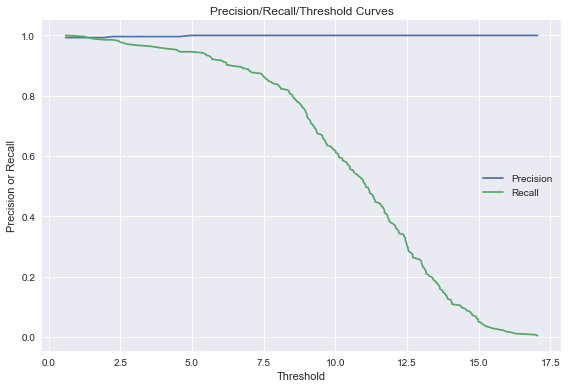

In [9]:
plot_precision_recall_threshold_curve(precision, recall, threshold)

***Notes on precision/recall/threshold curve***
- To increase the precision which jobs predicts at (e.g. ensure that whenever jobs predicts a product is satisfactory it actually is) the threshold for the decision function could be slightly increased.

### Precision Recall Curve

In [10]:
def plot_precision_recall_curve(precisions, recalls):
    plt.style.use("seaborn")
    fig, ax = plt.subplots()
    ax.plot(recalls, precisions, label = "Precision")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision/Recall Curve")
    plt.tight_layout()
    plt.show()

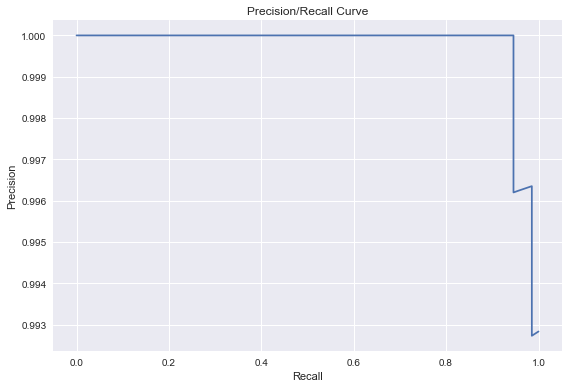

In [11]:
plot_precision_recall_curve(precision, recall)

***Precision Recall Curve Notes***
- jobs could achieve a precision of 100% while still having a recall > 90%
    - Whenever jobs predicts a satisfactory product it will be correct (higher precision)
    - However, jobs will classify some satisfactory product as defective (lower recall)

### ROC curve

In [12]:
def plot_roc_curve(y, y_scores, label = None):
    
    #Get tpr and fpr arrays
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    
    #Plot Curve
    plt.style.use("seaborn")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label = label)
    ax.plot([0,1], [0,1], label = "Random Classification", color = "k", linestyle = "--", linewidth = 1)
    ax.set_title("ROC Curve")
    ax.set_xlabel("False positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc = "lower right")
    plt.tight_layout()
    plt.show()
    
    #Print and return area under ROC curve
    area = roc_auc_score(y, y_scores)
    print("Area under ROC Curve: {}".format(area))
    return area
    

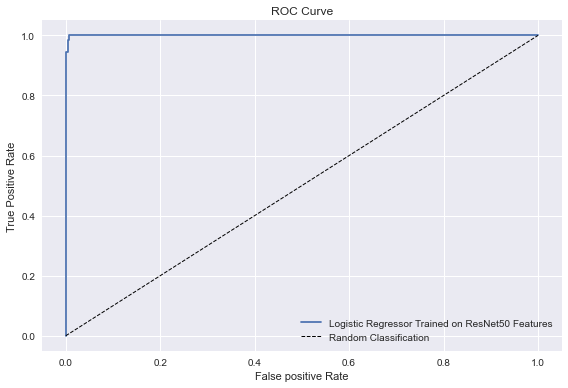

Area under ROC Curve: 0.9997532659792744


In [13]:
area = plot_roc_curve(y, results["scores"], label = "Logistic Regressor Trained on ResNet50 Features")

***Notes on ROC curve***
- ROC curve nearly perfect (0.9997 area under curve when a perfect area under the curve score is 1.0000)
- Normally this would cause concern of overfitting, however, this ROC curve was calculated on the validation set and not the test set
    - The model had never seen any of the images these metrics were calculated on
***
## Next Steps
1. Adjust classification threshold (value above which an instance is classified as a 1, below which an instance is classified as a 0).
    - Cross validate on training data to find best value then compare to validation set
2. Asses model performance on biased testing set -> Assume a 90/10 split of satisfactory to defective products